The Flexible Image Transport System (FITS) is the standard filetype used for storing data taken from a telescope. There are several Python packages that exist to help load FITS files into a Python data structure. However, the structure of a FITS file can vary significantly between telescopes, making it difficult to automate data preparation. Since we know what type of data we are processing, we can wrap a standard FITS loader with some additional logic to make this initial step slightly easier!

In this section, we show how ```specsuite``` can load / average several FITS files simultaneously. Unless you are processing data from one of the "supported" instruments (SBO, KOSMOS, or GMOS-N), you may also need to provide some additional information to help properly load your data.

<div class="admonition information">
    <p class="admonition-title">Note</p>
    <p>
         We are working on creating specific loading functions for commonly-used telescopes with long-slit spectrographs. Although we have a "default" loader, this can fail to account for the niche data layout of some telescopes. We have dedicated loading functions for: KOSMOS, GMOS-N.
    </p>
</div>

<div class="admonition warning">
    <p class="admonition-title">Warning</p>
    <p>
         Currently, the following functions can only load FITS files. Some observatories will save data in a compressed format (such as GZIP compressed files). If you would like to use these loading functions, please unzip your data beforehand.
    </p>
</div>

## __Basic Usage__
Across all documentation, we will be using the sample data location in the "data/" directory on the ```specsuite``` repository. Although we recommend splitting up your exopsures into separate "calibration/" and "target/" folders, this is not strictly necessary for our loading functions to work. For reference, here is the structure of our data...

```bash
📂KOSMOS
|
└──📂calibrations
│  │   📜bias.0001.fits
│  │   📜bias.0002.fits
│  │   📜bias.0003.fits
│  │   📜flatfield.0004.fits
│  │   📜flatfield.0005.fits
│  │          ⋮
│   
└──📂target
   │   📜toi3884.0006.fits
   │   📜toi3884.0007.fits
   │   📜toi3884.0008.fits
   │   📜toi3884.0009.fits
   │   📜toi3884.0010.fits
   │          ⋮
```

### _Loading Multiple Images_
There are many types of exposures you may wish to load into Python as separate Numpy arrays. Using ```collect_images_array()```, you can do just that! This function requires a directory to search for FITS files and a 'tag' to look for in the filenames contained within that directory. So, if we wanted to separately load in each "toi3884" exposure from our data directory...


Searching for files with 'toi3884' tag...
------------------------------------------
toi3884.0033.fits
toi3884.0034.fits
toi3884.0035.fits
toi3884.0036.fits
toi3884.0037.fits


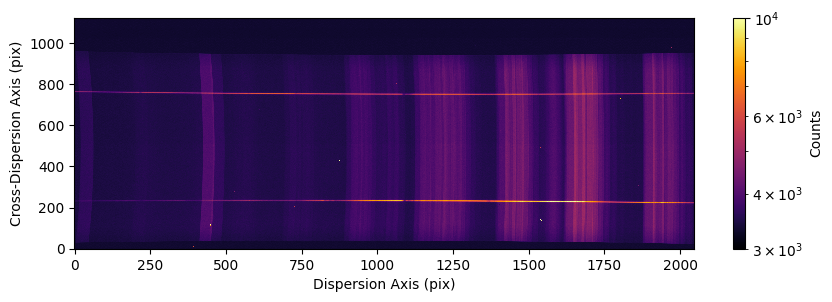

In [1]:
import specsuite as ss

# Specifies where to look for files / how to load them
FILEPATH = "../data/KOSMOS/target"
TAG = "toi3884"
INSTRUMENT = "kosmos"

# Loads an array of data images
data_images = ss.collect_images_array(
    path = FILEPATH,
    tag = TAG,
    instrument = INSTRUMENT,
    debug = True,
)

# Plots the first data image
ss.plot_image(data_images[0], norm='log', vmin=3e3, vmax=1e4)

If a file fails to load, it will simply be skipped during the loading process. You can check which specific files failed to load using the ```debug``` argument. Another optional argument can be provided to specify which region of an image to keep...

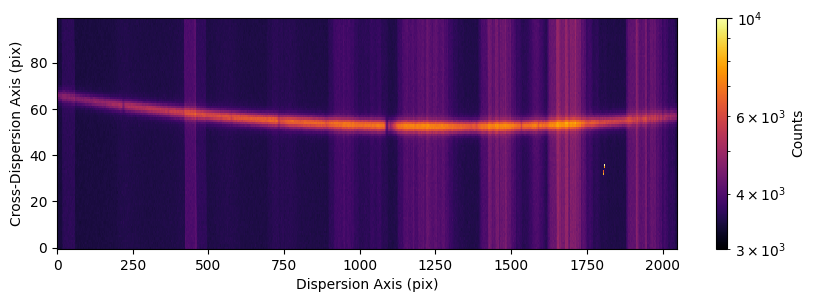

In [2]:
# Specifies which rows to keep from an image
DATA_REGION = (700, 800)

# Loads an array of data images
data_images = ss.collect_images_array(
    path = FILEPATH,
    tag = TAG,
    instrument = INSTRUMENT,
    crop_bds = DATA_REGION,
)

# Plots the first data exposure
ss.plot_image(data_images[0], norm='log', vmin=3e3, vmax=1e4)

You may also want to exclude specific files in your directory. To skip specific filenames, use the ```ignore``` argument...

In [3]:
# Name of the file in PATH to avoid loading
IGNORE = ["toi3884.0035.fits"]

# Loads all but one of the files PATH
data_images = ss.collect_images_array(
    path = FILEPATH,
    tag = TAG,
    ignore = IGNORE,
    instrument = INSTRUMENT,
    debug = True,
)


Searching for files with 'toi3884' tag...
------------------------------------------
toi3884.0033.fits
toi3884.0034.fits
toi3884.0036.fits
toi3884.0037.fits


### _Averaging Multiple Images_

A common practice for calibration images (i.e., biases, darks, flats, etc.) is the take the average of multiple exposures. This is done to minimize the impact of random, statistical fluctuations on your data calibration. To load the average of several files, you can use ```average_matching_files()``` with the same arguments used above...

In [4]:
FILEPATH = "../data/KOSMOS/calibrations"

bias = ss.average_matching_files(
    path = FILEPATH,
    tag = "bias",
    instrument = INSTRUMENT,
)

arclamp = ss.average_matching_files(
    path = FILEPATH,
    tag = "neon",
    instrument = INSTRUMENT,
)

flat = ss.average_matching_files(
    path = FILEPATH,
    tag = "flat",
    instrument = INSTRUMENT,
)

Note that you can specify a sub-region to keep just like in ```collect_images_array()```.

### _Compiling FITS Metadata_
FITS headers often contain useful metadata (i.e., exposure time, telescope name, airmass, etc.). While we cannot predict which exact keywords are used in a given file, we create a dictionary filled with all of the key-value pairs found within the FITS header. This is as simple as providing a path and tag...

In [5]:
FILEPATH = "../data/KOSMOS/target"

metadata = ss.load_metadata(
    path = FILEPATH,
    tag = "toi3884",
)

This function can compile the metadata from multiple images into a single dictionary. If the value is identical between all images, then the dictionary value will just contain a single value...

In [6]:
print("Exposure Time:", metadata["EXPTIME"])
print("Instrument Name:", metadata["INSTRUME"])

Exposure Time: 66.0
Instrument Name: kosmos


If each exposure contains unique data, though, the the metadata dictionary will contain a list of all values. The order of each entry should align with the order that files were loaded in...

In [7]:
print("Airmass:", metadata["AIRMASS"])

Airmass: [2.12510104 2.10341395 2.08106647 2.06040547 2.04021965]


## __Common Errors__
### _Wrong Files Loading_
If you happen to have multiple types of exposures in a single directory, your provided tag matters a lot. For example, if my provided tag was "a", ```specsuite``` may load two different types of files together...

In [8]:
PATH = "../data/KOSMOS/calibrations"

bad_image = ss.average_matching_files(
    path = PATH,
    tag = "a",
    debug = True,
)


Searching for files with 'a' tag...
------------------------------------------
bias.0001.fits
bias.0002.fits
bias.0003.fits
bias.0004.fits
bias.0005.fits
flat.0029.fits
flat.0030.fits
flat.0031.fits
flat.0032.fits
flat.0033.fits
fluxcal.0215.fits

Image statistics for average 'a' image...
      Min: 3035.0
      Max: 53835.0
     Mean: 3771.595
      STD: 422.12


If your files have unexpected features, using ```debug = True``` can help you quickly check which files are being loaded.

### _The Loaded Data is 'None'_

If ```specsuite``` fails to load a file, it will attempt to skip over the file and carry on until the next valid file is loaded. However, if all files fail to load (or no valid files were found in the provided directory) then the expected return is 'None'. For example...

In [9]:
data = ss.average_matching_files(
    path = "../data/KOSMOS/calibrations",
    tag = "bad tag",
    debug = True,
)


Searching for files with 'bad tag' tag...
------------------------------------------


The easiest way to fix this is to use the ```debug``` argument to verify whether the expected files are successfully loaded.